# Test Gridmask

In [47]:
from data import GraphemeDataset
from data import load_feather_data
import matplotlib.pylab as plt
import numpy as np

In [56]:
HEIGHT = 128
WIDTH = 128
csv_path = 'BengaliData/'
feather_data_path = 'BengaliData/feather_resize128/'

train_df, data_full = load_feather_data(csv_path, feather_data_path)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

train_dataset = GraphemeDataset(data_full,
                                train_df,
                                HEIGHT,
                                WIDTH,
                                transform=True)

data full shape: (200840, 16385)


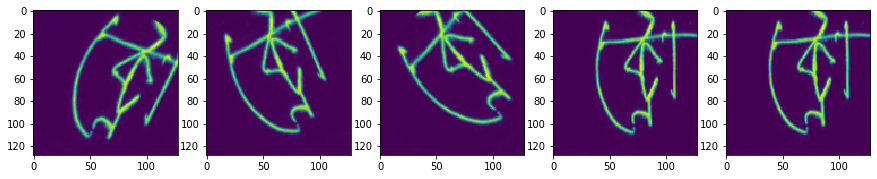

In [60]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    example = train_dataset[0]
    image = example[0].reshape(128, 128)
    ax[i].imshow(image)

# Include Gridmask option in dataset

In [70]:
from gridmask import GridMask
from torch.utils.data import Dataset,DataLoader

class GraphemeDataset(Dataset):
    def __init__(self, df, label, height, width, transform=True,
                 gridmask=False, image_mode='gray',
                 album_transform=None):
        self.df = df
        self.label = label
        self.transform = transform
        self.data = df.iloc[:, 1:].values
        self.random_earse = RandomErasing(p=1)
        self.width = width
        self.height = height
        self.aug = get_transform(image_mode)
        self.image_mode = image_mode
        self.norm = normalize
        self.album_transform = album_transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(np.float)
        image = self.data[idx, :].reshape(self.height, self.width).astype(np.uint8)
       # image1 = image
       # print('fdsafsafsA:', type(image), image.max(), image.min())
        if self.image_mode == 'rgb':
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            if self.aug:
                augment = self.aug(image=image)
                image = augment['image']
        if self.album_transform:
            res = self.album_transform(image=image)
            image = res['image'].astype(np.float32)

        #image = np.clip(image, 0.0, 255.0)
        image = np.asarray(image, dtype=np.float32)
        if self.image_mode == 'gray':
            image /= 255.0
            image = np.expand_dims(image, 0)
        else:
            image = self.norm(image)
            image = np.transpose(image, (2, 0, 1))


        return image, label1, label2, label3#, image1

In [79]:
import albumentations

transforms_train = albumentations.Compose([
    GridMask(num_grid=(3, 7), p=1),
])

In [80]:
from data import RandomErasing, get_transform, normalize

train_dataset = GraphemeDataset(data_full,
                                train_df,
                                HEIGHT,
                                WIDTH,
                                transform=True,
                                album_transform=transforms_train)

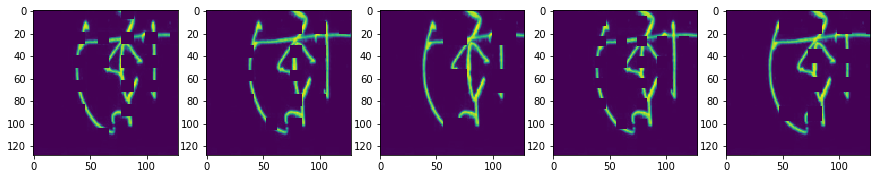

In [81]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    example = train_dataset[0]
    image = example[0].reshape(128, 128)
    ax[i].imshow(image)